# Лінійна регресія: перенавчання і регуляризація

У цьому завданні ми на прикладах побачимо, як перенавчаються лінійні моделі, розберемо, чому так відбувається, і з'ясуємо, як діагностувати та контролювати перенавчання.

В усіх комірках, де вказаний коментар з інструкціями, потрібно написати код, який виконує ці інструкції. Решту комірок із кодом (без коментарів) треба просто виконати. Крім того, у завданні необхідно відповідати на запитання; відповіді потрібно вписувати після виділеного слова "__Відповідь:__".

In [1]:
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
%matplotlib inline

Ми будемо працювати з датасетом __"bikes_rent.csv"__, у якому по днях записані календарна інформація та погодні умови, що характеризують автоматизовані пункти прокату велосипедів, а також кількість прокатів у цей день. Останнє ми будемо передбачати; таким чином, ми будемо розв'язувати завдання регресії.

### Ознайомлення з даними

## Завдання 1

Завантажте датасет за допомогою функції __pandas.read_csv__ у змінну __df__. Виведіть перші 5 рядків, щоб переконатися в коректному зчитуванні даних:

In [2]:
df = pd.read_csv("bikes_rent.csv")
df.head()

,season,yr,mnth,holiday,weekday,workingday,weathersit,temp,atemp,hum,windspeed(mph),windspeed(ms),cnt
0,1,0,1,0,6,0,2,14.110847,18.18125,80.5833,10.749882,4.805490,985
1,1,0,1,0,0,0,2,14.902598,17.68695,69.6087,16.652113,7.443949,801
2,1,0,1,0,1,1,1,8.050924,9.47025,43.7273,16.636703,7.437060,1349
3,1,0,1,0,2,1,1,8.200000,10.60610,59.0435,10.739832,4.800998,1562
4,1,0,1,0,3,1,1,9.305237,11.46350,43.6957,12.522300,5.597810,1600


Для кожного дня прокату відомі такі ознаки:
* _season_: 1 — весна, 2 — літо, 3 — осінь, 4 — зима
* _yr_: 0 — 2011, 1 — 2012
* _mnth_: від 1 до 12
* _holiday_: 0 — немає свята, 1 — є свято
* _weekday_: від 0 до 6
* _workingday_: 0 — неробочий день, 1 — робочий день
* _weathersit_: оцінка сприятливості погоди від 1 (чистий, ясний день) до 4 (злива, туман)
* _temp_: температура в Цельсіях
* _atemp_: температура за відчуттями в Цельсіях
* _hum_: вологість
* _windspeed(mph)_: швидкість вітру в милях за годину
* _windspeed(ms)_: швидкість вітру в метрах за секунду
* _cnt_: кількість орендованих велосипедів (це цільова ознака, її ми будемо передбачати)

Отже, у нас є речові, бінарні та номінальні (порядкові) ознаки, і з усіма з них можна працювати як з речовими. З номінальними ознаками теж можна працювати як з речовими, тому що на них заданий порядок. Давайте подивимося на графіках, як цільова ознака залежить від решти.

Побудуйте графіки залежностей атрибутів від кількості поїздок. Іншими словами, вам потрібно побудувати 12 графіків. На кожному має бути зображена залежність чергового атрибута від змінної **cnt**.

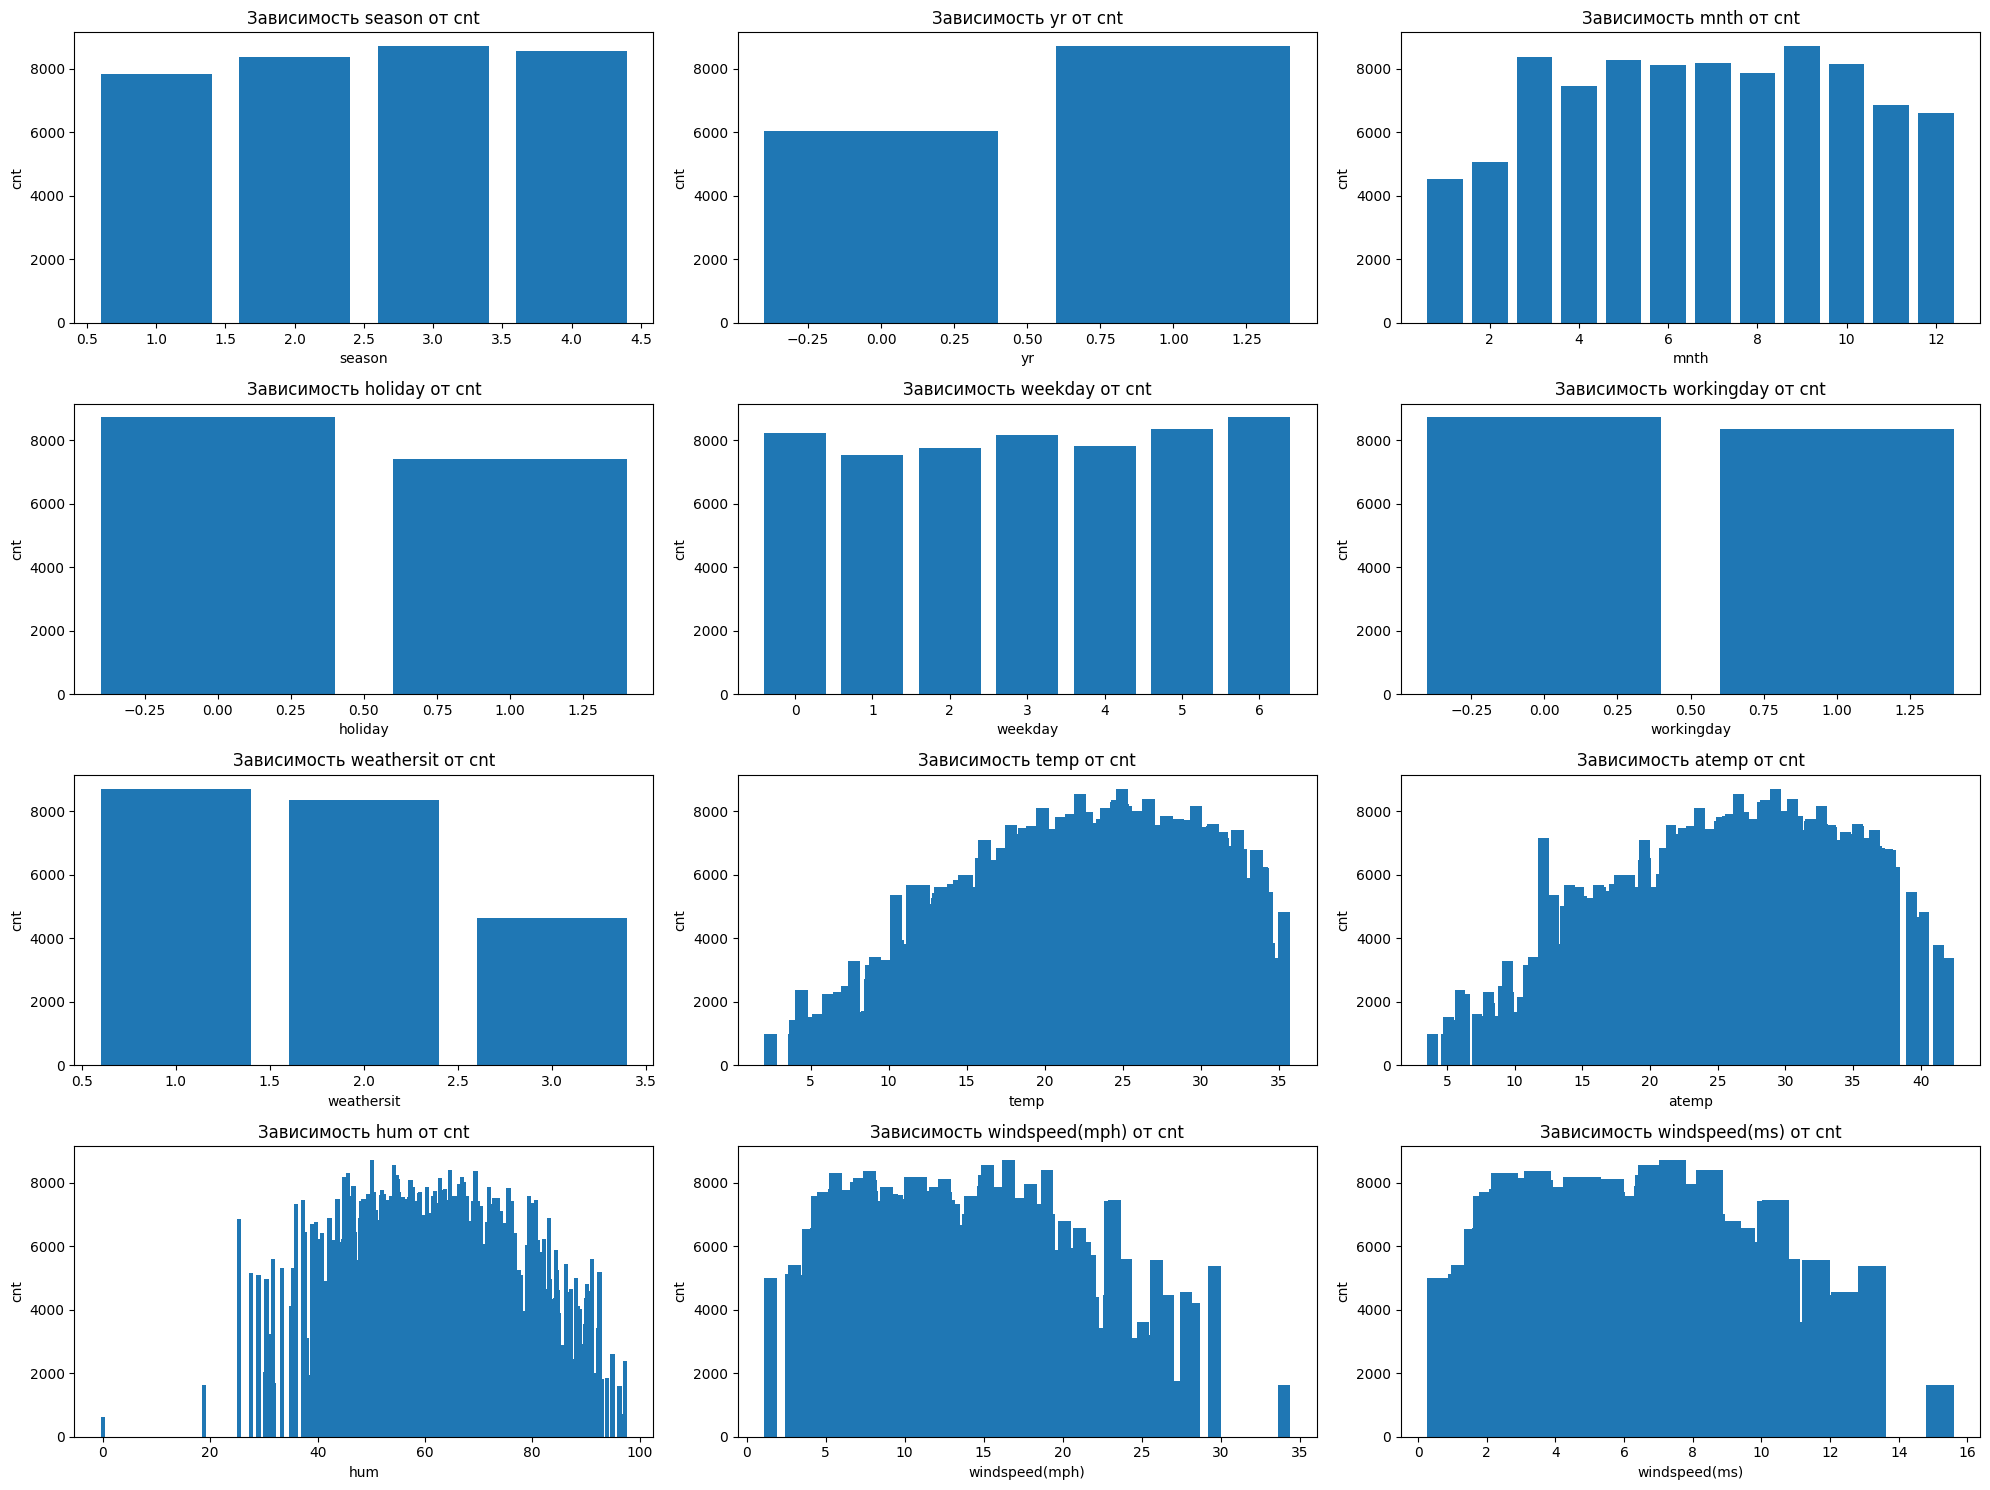

In [3]:
# Визначаємо атрибути: Список атрибутів, котрим потрібно побудувати графіки. (df.columns)
attributes = ['season', 'yr', 'mnth', 'holiday', 'weekday', 'workingday', 'weathersit', 'temp', 'atemp', 'hum', 'windspeed(mph)', 'windspeed(ms)']

plt.figure(figsize=(20, 15))
# За допомогою циклу створюємо графіки кожного атрибута.
for i, attribute in enumerate(attributes):
    plt.subplot(4, 3, i + 1)  # Створення підграфіка у сітці 4x3
    plt.bar(df[attribute], df['cnt']) # Будує графік розсіювання  для поточного атрибуту та змінної cnt.
    plt.xlabel(attribute) # Встановлює підписи осей.
    plt.ylabel('cnt') # Встановлює заголовок для підграфіка.
    plt.title(f'Зависимость {attribute} от cnt') # робить компонування графіків акуратним

plt.tight_layout()
plt.show()

__Запитання:__
1. Яким є характер залежності кількості прокатів від місяця?
1. Вкажіть одну або дві ознаки, від яких кількість прокатів скоріше за все залежить лінійно.

In [ ]:
# Види залежностей які можна виявити:
# • Лінійна залежність:
# ∘ Пряма лінійна залежність: Якщо одна змінна збільшується, інша змінна теж збільшується прямо пропорційно. y=ax+b
# ∘ Обратна лінійна залежність: Якщо одна змінна збільшується, інша змінна зменшується прямо пропорційно. y=−ax+b
# • Нелінійна залежність:
# ∘ Квадратична залежність: Зміна однієї змінної призводить до квадратичної зміни іншої. y = ax^2 + bx + c
# ∘ Кубічна залежність: Зміна однієї змінної призводить до кубічної зміни іншої. 𝑦 = 𝑎𝑥^3 + bx^2 + cx + d
# ∘ Експоненціальна залежність: Одна змінна змінюється експоненціально відносно іншої. y=ae^bx
# ∘ Логарифмічна залежність: Одна змінна змінюється логарифмічно відносно іншої. y=alog(x)+b
# • Сезонна або циклічна залежність:
# ∘ Сезонна залежність: Зміни відбуваються за певними періодами, повторюючись регулярно. (Приклад: Кількість продажів зростає під час свят і знижується після них.)
# ∘ Циклічна залежність: Зміни відбуваються у відповідь на економічні або інші цикли, які можуть бути нерегулярними. (Приклад: Економічний цикл росту і спаду.)
# • Кореляційна залежність:
# ∘ Позитивна кореляція: Збільшення однієї змінної призводить до збільшення іншої. (Приклад: Зріст доходу та рівня витрат.)
# ∘ Негативна кореляція: Збільшення однієї змінної призводить до зменшення іншої. (Приклад: Зріст кількості машин та зниження рівня забруднення повітря (у випадку переходу на екологічні автомобілі).)
# • Причинно-наслідкова залежність:
# ∘ Пряма причинно-наслідкова залежність: Одна змінна є причиною зміни іншої. (Приклад: Кількість витрачених годин на навчання та результати тестів.)
# ∘ Обратна причинно-наслідкова залежність: Наслідок впливає на причину. (Приклад: Успішність проекту впливає на мотивацію команди.)
# • Стохастична або випадкова залежність:
# ∘ Стохастична залежність: Зміни однієї змінної пов'язані з випадковими коливаннями іншої. (Приклад: Коливання курсу акцій на фондовому ринку.)
# (Прям залежність , обернено залежні і незалежні)

1.   Сезонна залежність
2.   Пряма лінійна залежність: Temp, Season

## Завдання 2

Давайте більш строго оцінимо рівень лінійної залежності між ознаками та цільовою змінною. Гарною мірою лінійної залежності між двома векторами є кореляція Пірсона. Нам уже доводилося мати з нею справу раніше. Для її обчислення в pandas можна використовувати методи датафрейму: corr і corrwith.

Порахуйте кореляції всіх ознак, окрім останньої, з останньою за допомогою методу `corrwith`.

In [4]:
# Оцінити рівень лінійної залежності між ознаками та цільовою змінною означає визначити, наскільки сильно і в якому напрямку
# кожна ознака (наприклад, температура, вологість) пов'язана з цільовою змінною (наприклад, кількістю прокатів).
# Для цього використовують кореляцію, яка показує ступінь лінійного зв'язку.

# Обчислення кореляцій всіх ознак крім останнього
# .iloc використовується для вибору певних рядків та стовпців із DataFrame за індексами. В даному випадку, df.iloc[:, :-1] вибирає всі рядки та всі стовпці, крім останнього.
correlation_matrix = df.iloc[:, :-1].corr()
correlation_matrix # найближчі до 1/-1 - висока кореляція => лінійна залежність

# Кореляція показує, як сильно змінюються ознаки разом. Значення будуть від -1 до 1:
# 1: Повна позитивна кореляція. - Коли одна ознака збільшується, інша також збільшується.
# -1: Повна негативна кореляція. - Коли одна ознака збільшується, інша зменшується.
# 0: Немає лінійної залежності.

,season,yr,mnth,holiday,weekday,workingday,weathersit,temp,atemp,hum,windspeed(mph),windspeed(ms)
season,1.000000,-0.001844,0.831440,-0.010537,-0.003080,0.012485,0.019211,0.334315,0.342876,0.205445,-0.229046,-0.229046
yr,-0.001844,1.000000,-0.001792,0.007954,-0.005461,-0.002013,-0.048727,0.047604,0.046106,-0.110651,-0.011817,-0.011817
mnth,0.831440,-0.001792,1.000000,0.019191,0.009509,-0.005901,0.043528,0.220205,0.227459,0.222204,-0.207502,-0.207502
holiday,-0.010537,0.007954,0.019191,1.000000,-0.101960,-0.253023,-0.034627,-0.028556,-0.032507,-0.015937,0.006292,0.006292
weekday,-0.003080,-0.005461,0.009509,-0.101960,1.000000,0.035790,0.031087,-0.000170,-0.007537,-0.052232,0.014282,0.014282
workingday,0.012485,-0.002013,-0.005901,-0.253023,0.035790,1.000000,0.061200,0.052660,0.052182,0.024327,-0.018796,-0.018796
weathersit,0.019211,-0.048727,0.043528,-0.034627,0.031087,0.061200,1.000000,-0.120602,-0.121583,0.591045,0.039511,0.039511
temp,0.334315,0.047604,0.220205,-0.028556,-0.000170,0.052660,-0.120602,1.000000,0.991702,0.126963,-0.157944,-0.157944
atemp,0.342876,0.046106,0.227459,-0.032507,-0.007537,0.052182,-0.121583,0.991702,1.000000,0.139988,-0.183643,-0.183643
hum,0.205445,-0.110651,0.222204,-0.015937,-0.052232,0.024327,0.591045,0.126963,0.139988,1.000000,-0.248489,-0.248489


In [5]:
# Обчислення кореляцій всіх ознак з останнім стовпцем 'cnt'
correlations_with_cnt = df.corrwith(df['cnt'])
correlations_with_cnt # Показники, близькі до 1 або -1, показують сильну лінійну залежність із цільовою змінною.

,0
season,0.406100
yr,0.566710
mnth,0.279977
holiday,-0.068348
weekday,0.067443
workingday,0.061156
weathersit,-0.297391
temp,0.627494
atemp,0.631066
hum,-0.100659


У вибірці є ознаки, що корелюють із цільовою, а отже, завдання можна розв'язувати лінійними методами.

За графіками видно, що деякі ознаки схожі між собою. Тому давайте також порахуємо кореляції між речовими ознаками.

## Завдання 3

Порахуйте попарні кореляції між ознаками temp, atemp, hum, windspeed(mph), windspeed(ms) і cnt
за допомогою методу corr:

In [6]:
# Попарні кореляції вимірюють зв'язок між двома змінними. Вони показують, як зміни в одній змінній пов'язані зі змінами в іншій.
selected_features = ['temp', 'atemp', 'hum', 'windspeed(mph)', 'windspeed(ms)', 'cnt']
correlations = df[selected_features].corr()
correlations

,temp,atemp,hum,windspeed(mph),windspeed(ms),cnt
temp,1.000000,0.991702,0.126963,-0.157944,-0.157944,0.627494
atemp,0.991702,1.000000,0.139988,-0.183643,-0.183643,0.631066
hum,0.126963,0.139988,1.000000,-0.248489,-0.248489,-0.100659
windspeed(mph),-0.157944,-0.183643,-0.248489,1.000000,1.000000,-0.234545
windspeed(ms),-0.157944,-0.183643,-0.248489,1.000000,1.000000,-0.234545
cnt,0.627494,0.631066,-0.100659,-0.234545,-0.234545,1.000000


На діагоналях, як і належить, стоять одиниці. Однак у матриці є ще дві пари сильно корелюючих стовпців: temp і atemp (корелюють за своєю природою) і два windspeed (тому що це просто переведення одних одиниць в інші). Далі ми побачимо, що цей факт негативно позначається на навчанні лінійної моделі.

Насамкінець подивимося середні ознак (метод mean), щоб оцінити масштаб ознак і частки 1 у бінарних ознак.

## Завдання 4

Виведіть середні ознак.

In [7]:
df.mean()

,0
season,2.496580
yr,0.500684
mnth,6.519836
holiday,0.028728
weekday,2.997264
workingday,0.683995
weathersit,1.395349
temp,20.310776
atemp,23.717699
hum,62.789406


Ознаки мають різний масштаб (їх середні значення сильно відрізняються windspeed(ms) (середнє 5.71) а cnt (середнє 4504.35)), отже, для подальшої роботи нам краще нормувати матрицю об'єкти-ознаки.

### Проблема перша: колінеарні ознаки(ознаки, які пов'язані між собою.)

Отже, у наших даних одна ознака дублює іншу, і є ще дві дуже схожі. Звичайно, ми могли б одразу видалити дублікати, але давайте подивимося, як відбувалося б навчання моделі, якби ми не помітили цю проблему.

Для початку проведемо масштабування, або стандартизацію ознак: з кожної ознаки віднімемо її середнє і поділимо на стандартне відхилення. Це можна зробити за допомогою методу scale.

Крім того, необхідно перемішати вибірку, це буде потрібно для крос-валідації.

In [8]:
from sklearn.preprocessing import scale
from sklearn.utils import shuffle

In [9]:
# Функція shuffle перемішує рядки в DataFrame df. Аргумент random_state=42 фіксує випадковий порядок, щоб результат відтворювався.
df_shuffled = shuffle(df, random_state=42)
# Функція scale нормалізує ознаки у DataFrame df_shuffled. Нормалізація наводить ознаки одного масштабу, зазвичай в діапазон [0, 1] або з середнім 0 і стандартним відхиленням 1.
X = scale(df_shuffled[df_shuffled.columns[:-1]])
# y — це цільова змінна (це змінна, яку намагаємось передбачити або пояснити за допомогою інших змінних (ознак) у моделі.
# Наприклад, у задачі прогнозування продажів, цільова змінна може бути кількістю проданих одиниць) зі стовпця "cnt" в df_shuffled.
y = df_shuffled["cnt"]

Давайте навчимо лінійну регресію на наших даних і подивимося на ваги ознак.

In [10]:
from sklearn.linear_model import LinearRegression

model = LinearRegression() # Створює екземпляр моделі лінійної регресії.
# Навчає модель на даних X та y. X – це матриця ознак (нормалізовані дані). y - це цільова змінна (кількість).
model.fit(X, y)

model.coef_

array([ 5.70863796e+02,  1.02196538e+03, -1.41301745e+02, -8.67593446e+01,
        1.37225064e+02,  5.63918818e+01, -3.30226462e+02,  3.67483733e+02,
        5.85549386e+02, -1.45614306e+02,  1.24571384e+13, -1.24571384e+13])

## Завдання 5

Створіть об'єкт лінійного регресора, навчіть його на всіх даних і виведіть ваги моделі (ваги зберігаються у змінній `coef_` класу регресора). Можна виводити пари (назва ознаки, вага), скориставшись функцією `zip`, вбудованою в мову python. Назви ознак зберігаються у змінній `df.columns`.


In [11]:
from sklearn.linear_model import LinearRegression

regressor = LinearRegression() # Створює екземпляр моделі лінійної регресії
regressor.fit(X, y) # Навчає модель на даних X та y
# Встановлює формат відображення чисел із плаваючою точкою до чотирьох символів після коми.
pd.options.display.float_format = '{:.4f}'.format
# Створює словник, де ключами є назви ознак DataFrame df, а значеннями — відповідні їм ваги (коефіцієнти), отримані після навчання моделі.
weight_models = dict(zip(df.columns, regressor.coef_))
# Перетворює словник weight_models на DataFrame з одним рядком. Ключі словника стають стовпцями DataFrame.
weight_models = pd.DataFrame(weight_models, index=[0])
weight_models


,season,yr,mnth,holiday,weekday,workingday,weathersit,temp,atemp,hum,windspeed(mph),windspeed(ms)
0,570.8638,1021.9654,-141.3017,-86.7593,137.2251,56.3919,-330.2265,367.4837,585.5494,-145.6143,12457138390688.8848,-12457138390887.3457


In [12]:
# транспонуємо DataFrame тобто рядки стають стовпцями, а стовпці стають рядками
weight_models.T
# Температура і температура (temp, atemp) сильно впливають на цільову змінну, маючи великі позитивні коефіцієнти.
# Рік (yr) також має значний позитивний вплив.
# Швидкість вітру в різних одиницях (windspeed(mph), windspeed(ms)) мають величезні та протилежні коефіцієнти, що вказує на проблему з колінеарністю цих ознак.
# Місяць і вологість (mnth, hum) мають негативний вплив.
# Проблема колінеарності (наприклад, швидкість вітру) може негативно вплинути на модель, створюючи величезні коефіцієнти та нестабільність.

,0
season,570.8638
yr,1021.9654
mnth,-141.3017
holiday,-86.7593
weekday,137.2251
workingday,56.3919
weathersit,-330.2265
temp,367.4837
atemp,585.5494
hum,-145.6143


Ми бачимо, що ваги при лінійно-залежних ознаках за модулем значно більші, ніж при інших ознаках. Щоб зрозуміти, чому так сталося, згадаємо аналітичну формулу, за якою обчислюються ваги лінійної моделі в методі найменших квадратів:

$$w = (X^TX)^{-1} X^T y$$

Якщо в $X$ є колінеарні (лінійно-залежні) стовпці, матриця $X^TX$ стає виродженою, і формула перестає бути коректною. Чим більш залежні ознаки, тим менший визначник цієї матриці й тим гірша апроксимація $Xw \approx y$. Таку ситуацію називають _проблемою мультиколінеарності_.

З парою (temp, atemp) трохи менше корелюючих змінних такого не сталося, однак на практиці завжди варто уважно стежити за коефіцієнтами при схожих ознаках.

Для того щоб розв'язати проблему мультиколінеарності, потрібно скористатися регуляризатором. До оптимізуючого функціоналу додають $L_1$ або $L_2$ норму ваг, помножену на коефіцієнт регуляризації $\alpha$. У першому випадку метод називається Lasso, а у другому — Ridge.

Уяви, що ти маєш кілька іграшок, але деякі з них схожі. Щоб не заплутатися, ти вирішуєш залишити лише різні іграшки, а схожі прибрати. Регулятор це як фільтр для іграшок. Він допомагає забрати зайві чи схожі іграшки, щоб твої розрахунки були точнішими.
*   Lasso (L1) – якби ти вибрав лише одну іграшку із двох схожих.
*   Ridge (L2) - якби ти трохи знизив вагу схожих іграшок, щоб вони не заважали.

In [13]:
# feature_names - список(імена всіх стовпців в df) Вони потрібні, щоб знати, яка вага відповідає якій ознакі.
feature_names = df.columns.tolist()

### Завдання 6
Давайте спробуємо навчити лінійні моделі з $L_1$ і $L_2$-регуляризацією, а далі порівняємо їхні ваги. Навчіть регресори Ridge і Lasso з параметрами за замовчуванням і переконайтеся, що проблема з вагами вирішилась.

Навчіть лінійну модель з $L_1$-регуляризацією (клас Lasso) і виведіть ваги.

In [14]:
from sklearn.linear_model import Lasso

# Створюємо та навчаємо модель Lasso
L1 = Lasso()
L1.fit(X, y)

# Створюємо словник ваг
lasso = {}
# feature_names – це список назв ознак
# L1.coef_ – це список ваг цих ознак
# Ми використовуємо zip(feature_names, L1.coef_), щоб поєднати кожну назву ознаки з його вагою.
for feature, weight in zip(feature_names, L1.coef_):
   # ми додаємо / оновлюємо запис у словнику lasso
    lasso[feature] = weight

# Перетворюємо словник на DataFrame
# list(lasso.items()) – перетворює словник lasso на список пар (ключ, значення).
# pd.DataFrame(..., columns=['Feature', 'Weight']) – створює DataFrame зі списку пар. Встановлює назви стовпців як 'Feature' та 'Weight'.
lasso_df = pd.DataFrame(list(lasso.items()), columns=['Feature', 'Weight'])

# Змінюємо формат чисел на float
# lasso_df['Weight'] = lasso_df['Weight'].apply(lambda x: f"{x:.10f}")

# Виводимо DataFrame
# lasso_df.iterrows() – ітератор, який проходить по кожному рядку DataFrame. Повертає кортеж (index, row), де index - це індекс рядка, а row - це сам рядок у вигляді об'єкта Series.
for index, row in lasso_df.iterrows():
    print(f"{row['Feature']}: {row['Weight']}")

season: 560.2416160308861
yr: 1019.4634940657196
mnth: -128.73062703678696
holiday: -86.15278133371106
weekday: 137.34789390496314
workingday: 55.21237064135668
weathersit: -332.3698569623487
temp: 376.3632362096943
atemp: 576.530793504555
hum: -144.12915500348583
windspeed(mph): -197.1396894024843
windspeed(ms): -2.8051404183533485e-08


In [15]:
# Виводимо DataFrame у вигляді таблиці
lasso_df

,Feature,Weight
0,season,560.2416
1,yr,1019.4635
2,mnth,-128.7306
3,holiday,-86.1528
4,weekday,137.3479
5,workingday,55.2124
6,weathersit,-332.3699
7,temp,376.3632
8,atemp,576.5308
9,hum,-144.1292


Навчіть лінійну модель з $L_2$-регуляризацією (клас Ridge) і виведіть ваги.

In [16]:
from sklearn.linear_model import Ridge

# Створюємо та навчаємо модель Ridge
ridge = Ridge()
ridge.fit(X, y)


# Створюємо словник ваг
ridge_weights = {}
# feature_names – це список назв ознак
# ridge.coef – це список ваг цих ознак
# Ми використовуємо zip щоб поєднати кожну назву ознаки з його вагою.
for feature, weight in zip(feature_names, ridge.coef_):
   # ми додаємо / оновлюємо запис у словнику ridge_weights
    ridge_weights[feature] = weight

# Перетворюємо словник на DataFrame
# ridge_weights.items()) – перетворює словник ridge_weights на список пар (ключ, значення).
# pd.DataFrame(..., columns=['Feature', 'Weight']) – створює DataFrame зі списку пар. Встановлює назви стовпців як 'Feature' та 'Weight'.
ridge_df = pd.DataFrame(list(ridge_weights.items()), columns=['Feature', 'Weight'])

# Виводимо DataFrame
for index, row in ridge_df.iterrows():
    print(f"{row['Feature']}: {row['Weight']}")

season: 563.0645722520181
yr: 1018.9483787875305
mnth: -131.87332028247715
holiday: -86.74609799709232
weekday: 138.00511117871918
workingday: 55.90311037506467
weathersit: -332.34978849907367
temp: 386.45788919190807
atemp: 566.3470470600669
hum: -145.07132729867195
windspeed(mph): -99.25944108179067
windspeed(ms): -99.25944115434177


In [17]:
# Виводимо DataFrame у вигляді таблиці
ridge_df

,Feature,Weight
0,season,563.0646
1,yr,1018.9484
2,mnth,-131.8733
3,holiday,-86.7461
4,weekday,138.0051
5,workingday,55.9031
6,weathersit,-332.3498
7,temp,386.4579
8,atemp,566.3470
9,hum,-145.0713


Коли ми говоримо, що проблема з вагами вирішена, це означає, що:

- Ваги не надто великі або маленькі: Проблема мультиколінеарності може викликати дуже великі або дуже маленькі значення ваги. Якщо ваги виглядають нормальними після застосування L1 (Lasso) та L2 (Ridge) регуляризації, це означає, що проблема вирішена.

- Усі важливі ознаки враховані: Регуляризація допомагає зробити модель стабільнішою та враховує важливі ознаки. Якщо після регулювання ваги ознак виглядають адекватно і модель працює добре, проблема вирішена.

- Модель не перевантажена: Регуляризація допомагає запобігти перевантаженню моделі (overfitting). Якщо після застосування регуляризації модель не перенавчається і добре передбачає дані, значить проблема вирішена.

### Завдання 7

На відміну від $L_2$-регуляризації, $L_1$ обнуляє ваги при деяких ознаках. Давайте поспостерігаємо, як змінюються ваги зі збільшенням коефіцієнта регуляризації $\alpha$.

Для кожного значення коефіцієнта з `alphas` навчіть регресор `Lasso` і запишіть ваги у список `coefs_lasso`, а потім навчіть `Ridge` і запишіть ваги у список`coefs_ridge`. Конвертуйте отримані списки в `np.array`.

In [18]:
# Задаємо діапазон значень для коефіцієнта регуляризації
alphas = np.arange(1, 500, 50)

# Списки для зберігання ваг
coefs_lasso = []
coefs_ridge = []

# Навчаємо моделі та зберігаємо ваг
for alpha in alphas:
    # Навчання Lasso
    lasso = Lasso(alpha=alpha)
    lasso.fit(X, y)
    coefs_lasso.append(lasso.coef_)

    # Навчання Ridge
    ridge = Ridge(alpha=alpha)
    ridge.fit(X, y)
    coefs_ridge.append(ridge.coef_)

# Перетворення списків у масиви numpy
coefs_lasso = np.array(coefs_lasso)
coefs_ridge = np.array(coefs_ridge)
print("coefs_lasso: ", coefs_lasso)
print("---------------------------------")
print("coefs_ridge: ", coefs_ridge)

coefs_lasso:  [[ 5.60241616e+02  1.01946349e+03 -1.28730627e+02 -8.61527813e+01
   1.37347894e+02  5.52123706e+01 -3.32369857e+02  3.76363236e+02
   5.76530794e+02 -1.44129155e+02 -1.97139689e+02 -2.80514042e-08]
 [ 4.10969632e+02  9.77019409e+02 -0.00000000e+00 -5.34489688e+01
   9.19434374e+01  1.75372118e+01 -3.18125568e+02  3.22829934e+02
   6.10031512e+02 -9.10689615e+01 -1.45066095e+02 -2.29892889e-08]
 [ 3.70077089e+02  9.35945490e+02  0.00000000e+00 -1.21619360e+01
   4.88886342e+01  0.00000000e+00 -3.08805664e+02  2.69417263e+02
   6.32502623e+02 -2.75042876e+01 -9.37749037e+01 -2.41657943e-08]
 [ 3.32835717e+02  8.91870058e+02  0.00000000e+00 -0.00000000e+00
   0.00000000e+00  0.00000000e+00 -2.79616688e+02  2.11052030e+02
   6.62920880e+02 -0.00000000e+00 -5.01551472e+01 -2.62789872e-08]
 [ 2.98134448e+02  8.45652857e+02  0.00000000e+00 -0.00000000e+00
   0.00000000e+00  0.00000000e+00 -2.35571345e+02  1.24144807e+02
   7.25379483e+02 -0.00000000e+00 -1.26461769e+01 -2.78775

Проаналізуйте динаміку ваг при збільшенні параметра регуляризації:

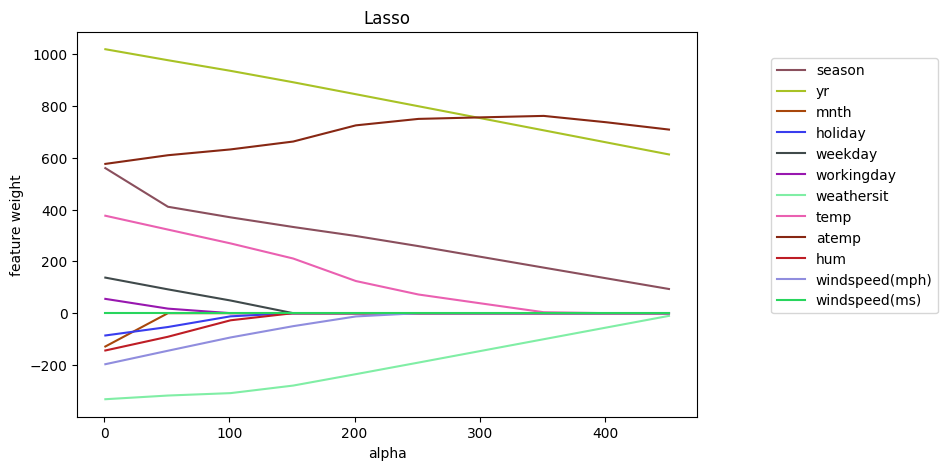

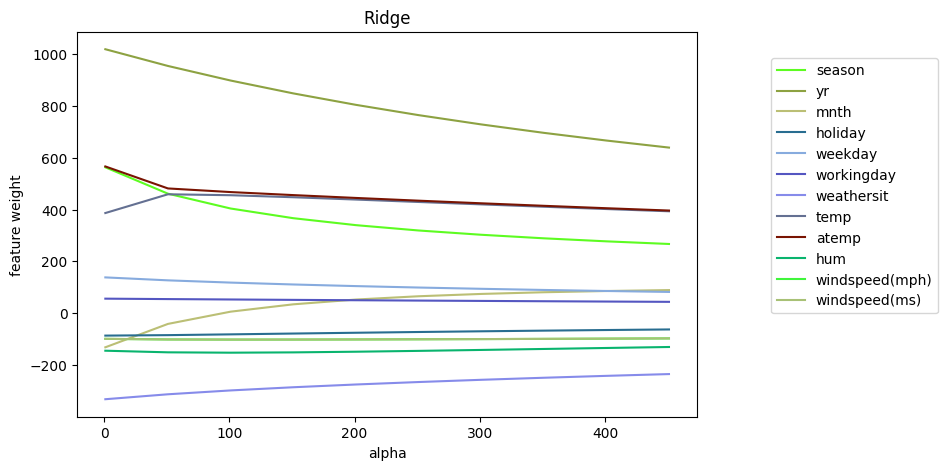

In [19]:
plt.figure(figsize=(8, 5))

for coef, feature in zip(coefs_lasso.T, df.columns):
    plt.plot(alphas, coef, label=feature, color=np.random.rand(3))

plt.legend(loc="upper right", bbox_to_anchor=(1.4, 0.95))
plt.xlabel("alpha")
plt.ylabel("feature weight")
plt.title("Lasso")

plt.figure(figsize=(8, 5))
for coef, feature in zip(coefs_ridge.T, df.columns):
    plt.plot(alphas, coef, label=feature, color=np.random.rand(3))

plt.legend(loc="upper right", bbox_to_anchor=(1.4, 0.95))
plt.xlabel("alpha")
plt.ylabel("feature weight")
plt.title("Ridge")

plt.show()

Проаналізуйте графіки та дайте відповіді на такі запитання.

1. Який регуляризатор (Ridge або Lasso) агресивніше зменшує ваги при одному й тому самому alpha?
  - Lasso більш агресивно зменшує ваги при тому самому alpha. Тому що Lasso може повністю обнуляти деякі ваги, роблячи їх рівними нулю, а Ridge просто зменшує їх, але не робить їх нульовими.
2. Що станеться з вагами Lasso, якщо alpha зробити дуже великим? Поясніть, чому так відбувається.
  - Коли значення alpha стає дуже великим, ваги Lasso зменшуються і можуть стати нульовими. Це відбувається тому, що Lasso намагається зробити ваги якнайменше та при великому alpha він може повністю обнулити деякі ваги.
3. Чи можна стверджувати, що `Lasso` виключає одну з ознак `windspeed` при будь-якому значенні `alpha > 0`? А Ridge? Вважається, що регуляризатор виключає ознаку, якщо коефіцієнт при ньому менший $10^{-3}$.
  - Lasso може виключити ознаку windspeed при досить великому значенні alpha, але Ridge не обов'язково виключатиме його повністю
4. Який із регуляризаторів підійде для відбору неінформативних ознак?
  - Lasso, бо зменшує швидше ваги, а деякі може зануляти\.

### Завдання 8

Далі будемо працювати з `Lasso`.

Отже, ми бачимо, що при зміні alpha модель по-різному підбирає коефіцієнти ознак. Нам потрібно вибрати найкраще alpha.

Для цього, по-перше, нам потрібна метрика якості. Будемо використовувати як метрику сам оптимізований функціонал методу найменших квадратів, тобто `Mean Square Error`.

По-друге, потрібно зрозуміти, на яких даних цю метрику рахувати. Не можна вибирати `alpha` за значенням MSE(`Mean Square Error`) на навчальній вибірці, тому що тоді ми не зможемо оцінити, як модель буде робити передбачення на нових для неї даних. Якщо ми виберемо одне розбиття вибірки на навчальну та тестову (це називається holdout), то налаштуємося на конкретні "нові" дані, і знову можемо перенавчитися. Тому будемо робити декілька розбиттів вибірки, на кожному пробувати різні значення alpha, а потім усереднювати MSE. Найзручніше робити такі розбиття крос-валідацією, тобто розділити вибірку на $K$ частин, і кожного разу брати одну з них як тестову, а з блоків, що залишилися, складати навчальну вибірку.

In [20]:
# Alpha – це число, яке допомагає моделі не запам'ятовувати надто багато деталей. Коли alpha мале, модель запам'ятовує багато деталей, але може помилятися на нових даних.
# Коли alpha велика, модель запам'ятовує лише найважливіші деталі, але теж може помилятися.
# Як alpha впливає на коефіцієнти?
# Коефіцієнти - це числа, які показують, наскільки сильно кожна особливість (наприклад, температура чи вітер) впливає на результат. Коли alpha змінюється, ці числа також змінюються.
# Навіщо вибирати найкраще alpha?
# Щоб модель працювала добре і не помилялася, потрібно знайти таке alpha, при якому модель запам'ятовує достатньо деталей,
# але не надто багато. Це допомагає їй бути точними і на нових даних.
# Як вибрати найкраще alpha?
# Ми можемо спробувати різні значення alpha та подивитися, при якому значення модель працює найкраще. Це значення і буде найкращим alpha.
# Приклад:
# У маленькому alpha модель запам'ятовує все, навіть неважливі деталі.
# У великому alpha модель запам'ятовує тільки найважливіше, але може забути щось потрібне.
# Ми шукаємо таке alpha, щоб модель не запам'ятовувала зайве, але й не забувала важливого.

Робити крос-валідацію для регресії в sklearn зовсім просто: для цього є спеціальний регресор, __LassoCV__, який бере на вхід список із alpha і для кожного з них обчислює MSE на крос-валідації. Після навчання (якщо залишити параметр cv=3 за замовчуванням) регресор буде містити змінну __mse\_path\___, матрицю розміру len(alpha) x k, k = 3 (число блоків у крос-валідації), що містить значення MSE на тесті для відповідних запусків. Крім того, у змінній alpha\_ буде зберігатися вибране значення параметра регуляризації, а в coef\_, традиційно, навчені ваги, що відповідають цьому alpha_.

Зверніть увагу, що регресор може змінювати порядок, у якому він проходить по alphas; для зіставлення з матрицею MSE краще використовувати змінну регресора alphas_.

Навчіть регресор `LassoCV` на всіх параметрах регуляризації з alpha. Побудуйте графік _усередненого_ за рядками `MSE` в залежності від `alpha` (використовуйте для цього функцію `create_plot`).

Виведіть вибране `alpha`, а також пари "ознака-коефіцієнт" для навченого вектора коефіцієнтів.

In [21]:
# функція create_plot, приймає чотири обов'язкові параметри: data (дані для побудови графіка), title (заголовок графіка), xlabel (назва осі X), ylabel (назва осі Y)
# і один необов'язковий параметр figsize (розмір фігури).
def create_plot(data, title, xlabel, ylabel, figsize=None):
    # Якщо figsize не заданий, розмір фігури буде за замовчуванням (15, 5).
    size = figsize or (15, 5)
    # Створює нову фігуру для графіка з заданим розміром.
    plt.figure(figsize=size)
    # Використовує функцію map для створення списку значень осі X, беручи перші елементи кожного кортежу в data.
    x = list(map(lambda e: e[0], data))
    # Використовує функцію map для створення списку значень осі Y, беручи другі елементи кожного кортежу в data.
    y = list(map(lambda e: e[1], data))
    # Створює лінійний графік за значеннями x та y.
    plt.plot(x, y, marker='D')
    # Встановлює заголовок графіка.
    plt.title(title)
    # Встановлює назву осі X.
    plt.xlabel(xlabel)
    # Встановлює назву осі Y.
    plt.ylabel(ylabel)

    plt.grid()
    plt.show()

season: 532.0189828413535
yr: 1015.0602226430595
mnth: -100.03952614356629
holiday: -83.29395987529904
weekday: 132.50446549095795
workingday: 51.557085614073735
weathersit: -330.5598567399817
temp: 370.67985503003405
atemp: 581.396931065498
hum: -140.00740550068844
windspeed(mph): -191.77140847135036
windspeed(ms): -2.6854702314758792e-08


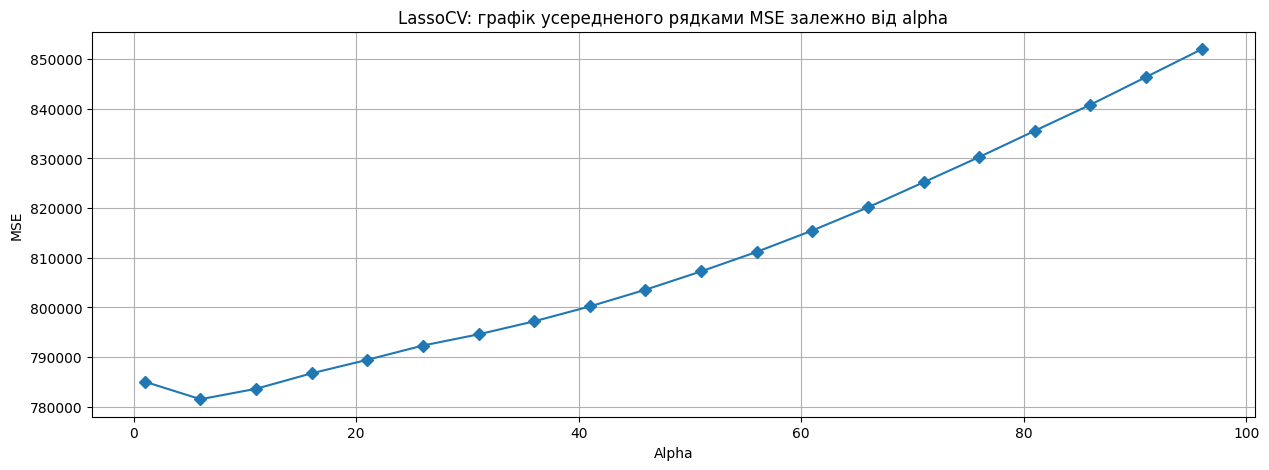

In [22]:
from sklearn.linear_model import LassoCV
# Задаємо діапазон значень alpha
alphas = np.arange(1, 100, 5)

# Ініціалізуємо та навчаємо регресор LassoCV
regressor = LassoCV(alphas=alphas, cv=3)
regressor.fit(X, y)
# Отримуємо значення MSE та alpha
mse_values = np.mean(regressor.mse_path_, axis=1)
alpha_values = regressor.alphas_
# Підготовка даних для графіка
data = list(zip(alpha_values, mse_values))
# Виведення пар "означення-коефіцієнт"
for feature, weight in zip(df.columns, regressor.coef_):
  print(f'{feature}: {weight}')


create_plot(data, "LassoCV: графік усередненого рядками MSE залежно від alpha", "Alpha", "MSE")


Отже, ми вибрали певний параметр регуляризації. Давайте подивимося, які б ми вибирали alpha, якби ділили вибірку лише один раз на навчальну та тестову, тобто розглянемо траєкторії MSE, що відповідають окремим блокам вибірки.

### Завдання 9

Виведіть значення `alpha`, що відповідають мінімумам `MSE` на кожному розбитті (тобто за стовпцями).
На трьох окремих графіках візуалізуйте стовпці `mse_path_`.


In [23]:
# Знайходимо індекси мінімальних значень MSE для кожного розбиття
index_min_alpha_mse = np.argmin(regressor.mse_path_, axis=0)

# Створити список пар alpha та MSE з відповідними індексами
alphas_min_mse = [regressor.alphas_[i] for i in index_min_alpha_mse]
mse_min_values = [np.min(regressor.mse_path_[:, i]) for i in range(regressor.mse_path_.shape[1])]

# Вивести результати
print("Alphas with minimum MSE:")
for alpha, mse in zip(alphas_min_mse, mse_min_values):
    print(f"Alpha = {alpha}, MSE = {mse:.6f}")


Alphas with minimum MSE:
Alpha = 6, MSE = 733725.760405
Alpha = 1, MSE = 799433.167369
Alpha = 51, MSE = 796979.895519


,Alpha,MSE
0,6,781531.0908
1,1,785055.1468
2,51,807264.7026


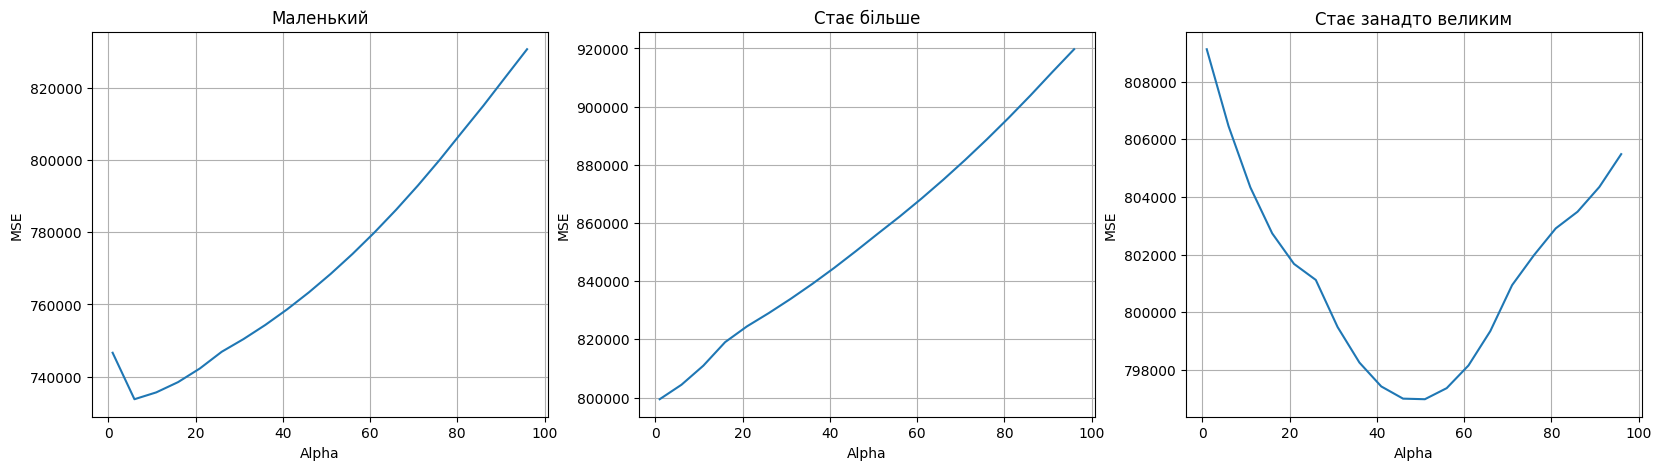

In [24]:
# Знайходимо індекси мінімальних значень MSE для кожного розбиття
index_min_alpha_mse = np.argmin(regressor.mse_path_, axis = 0)
# Виводить таблицю, де відображено значення alpha та відповідні їм мінімальні MSE.
display(pd.DataFrame({'Alpha': [data[index][0] for index in index_min_alpha_mse], 'MSE': [data[index][1] for index in index_min_alpha_mse]}))
# Создает три графика (по одному для каждого разбиения данных) и отображает, как изменяется MSE в зависимости от alpha.
fig, axs = plt.subplots(1, 3, figsize=(20,5))
# Створює три графіки та відображає, як змінюється MSE залежно від alpha.
for i, ax in enumerate(axs):
  ax.plot(alpha_values, regressor.mse_path_[:, i])
  ax.grid()
  ax.set_xlabel('Alpha')
  ax.set_ylabel('MSE')
  if i == 0:
     ax.set_title('Маленький')
  elif i == 1:
      ax.set_title('Стає більше')
  elif i == 2:
      ax.set_title('Стає занадто великим')

# Коли ми змінюємо значення alpha, MSE (помилка моделі) також змінюється.
# Коли alpha маленький: Модель може погано працювати, тому що регуляризація слабка, і модель може підлаштовуватися під шум даних.
# Коли alpha стає більшим: Регуляризація збільшується, модель стає простіше, і MSE починає зменшуватися, так як модель починає краще узагальнювати дані.
# Якщо alpha стає занадто великим: Модель стає занадто простою, і MSE може знову почати зростати, тому що вона не може добре підлаштуватися під дані.
# Графіки показують, як MSE змінюється із різними значеннями alpha. На графіці, де alpha найкраще, MSE буде найменшим.

На кожному розбитті оптимальне значення `alpha` своє, і йому відповідає велике MSE на інших розбиттях. Виходить, що ми налаштовуємося на конкретні навчальні та контрольні вибірки. При виборі `alpha` на крос-валідації ми вибираємо дещо "середнє", що даватиме прийнятне значення метрики на різних розбиттях вибірки.

### Завдання 10

Нарешті, як прийнято в аналізі даних, давайте проінтерпретуємо результат. Дайте відповіді на наступні запитання.

#### Запитання 1

В останній навченій моделі виберіть 4 ознаки з найбільшими (позитивними) коефіцієнтами (і випишіть їх), подивіться на візуалізації залежностей `cnt` від цих ознак, які ми зображали у блоці "Ознайомлення з даними". Чи видно зростаючу лінійну залежність `cnt` від цих ознак за графіками? Чи логічно стверджувати (виходячи зі здорового глузду), що чим більше значення цих ознак, тим більше людей захочуть взяти велосипеди?

__Відповідь:__

In [25]:
# Ми створюємо таблицю (DataFrame) із двома стовпцями:
# 'feature': Назви ознак нашого набору даних (df.columns[:-1]). Ми виключаємо останній стовпець, якщо він не є ознакою
# 'weight': Коефіцієнти ознак, які ми одержали з навченої моделі (regressor.coef_).
features = pd.DataFrame({'feature':df.columns[:-1], 'weight': regressor.coef_})
# Ми сортуємо таблицю за значенням 'weight' як спадання (ascending=False), беремо лише перші 4 рядки цієї відсортованої таблиці
features.sort_values(by=['weight'], ascending=False)[:4]

,feature,weight
1,yr,1015.0602
8,atemp,581.3969
0,season,532.0190
7,temp,370.6799


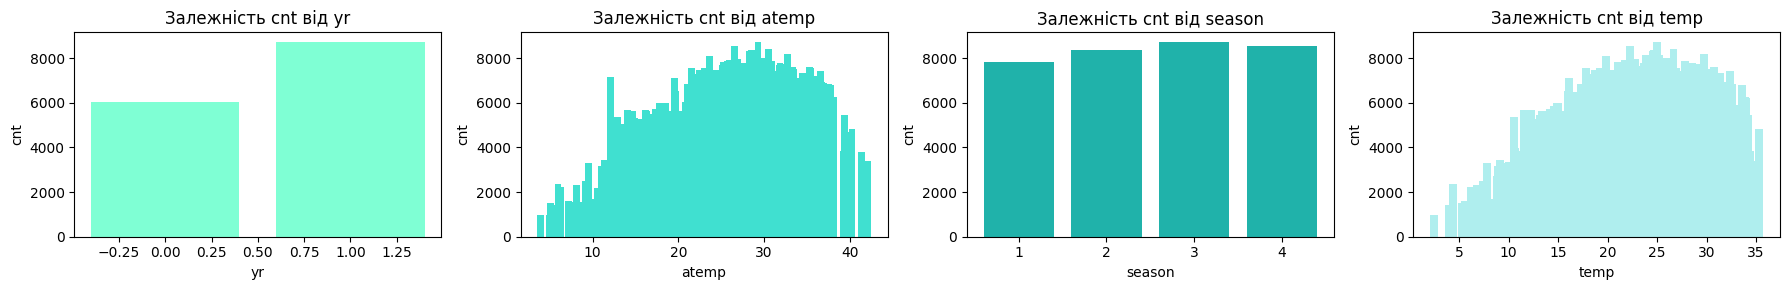

In [26]:
fig, axs = plt.subplots(1, 4, figsize=(18, 3))

# графік залежності cnt від ознаки 'yr'
axs[0].bar(df['yr'], df['cnt'], color='aquamarine')
axs[0].set_title('Залежність cnt від yr')
axs[0].set_xlabel('yr')
axs[0].set_ylabel('cnt')

# графік залежності cnt від ознаки 'atemp'
axs[1].bar(df['atemp'], df['cnt'], color='turquoise')
axs[1].set_title('Залежність cnt від atemp')
axs[1].set_xlabel('atemp')
axs[1].set_ylabel('cnt')

# графік залежності cnt від ознаки 'season'
axs[2].bar(df['season'], df['cnt'], color='lightseagreen')
axs[2].set_title('Залежність cnt від season')
axs[2].set_xlabel('season')
axs[2].set_ylabel('cnt')

# графік залежності cnt від ознаки 'temp'
axs[3].bar(df['temp'], df['cnt'], color='paleturquoise')
axs[3].set_title('Залежність cnt від temp')
axs[3].set_xlabel('temp')
axs[3].set_ylabel('cnt')

plt.tight_layout()
plt.show()


- Лінійна залежність найбільше простежується на графіках temp-cnt, atemp-cnt, можна стверджувати, що чим більша температура тим більше людей захочуть орендувати велосипед.

#### Запитання 2

Виберіть 3 ознаки з найбільшими за модулем негативними коефіцієнтами (і випишіть їх), подивіться на відповідні візуалізації. Чи видно лінійну залежність, що зменшується? Чи логічно стверджувати, що чим більша величина цих ознак, тим менше людей захочуть взяти велосипеди?

__Відповідь:__

In [27]:
features.sort_values(by=['weight'], ascending=True)[:3]

,feature,weight
6,weathersit,-330.5599
10,windspeed(mph),-191.7714
9,hum,-140.0074


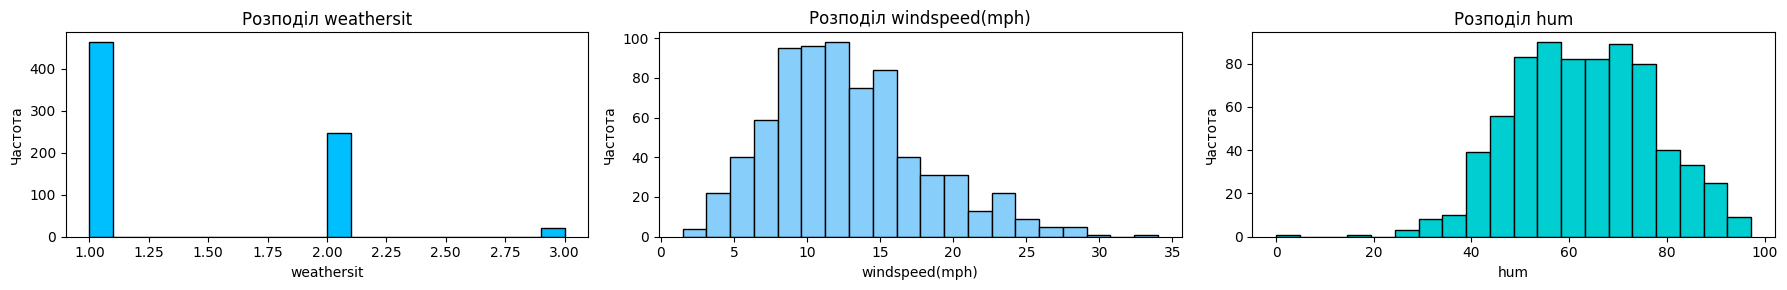

In [28]:
# Створюємо фігуру та осі для графіків
fig, axs = plt.subplots(1, 3, figsize=(18, 3))

# Гістограма для ознаки 'weathersit'
axs[0].hist(df['weathersit'], bins=20, color='deepskyblue', edgecolor='black')
axs[0].set_title('Розподіл weathersit')
axs[0].set_xlabel('weathersit')
axs[0].set_ylabel('Частота')

# Гістограма для ознаки 'windspeed(mph)'
axs[1].hist(df['windspeed(mph)'], bins=20, color='lightskyblue', edgecolor='black')
axs[1].set_title('Розподіл windspeed(mph)')
axs[1].set_xlabel('windspeed(mph)')
axs[1].set_ylabel('Частота')

# Гістограма для ознаки 'hum'
axs[2].hist(df['hum'], bins=20, color='darkturquoise', edgecolor='black')
axs[2].set_title('Розподіл hum')
axs[2].set_xlabel('hum')
axs[2].set_ylabel('Частота')

# Настраиваем расположение графиков
plt.tight_layout()
plt.show()

- Лінійна залежність по цим ознакам не настільки очевидна, але всеодно простежується і логічно стверджувати, що для weathersit - чим гірша погода тим меньше кількість прокатів, для windspeed(mph) - чим більша швидкість вітру тим меньша кількість прокатів, для hum - чим більша вологість повітря тим меньша кількість прокатів.

#### Запитання 3

Випишіть ознаки з коефіцієнтами, близькими до нуля (< 1e-3). Як ви думаєте, чому модель виключила їх із моделі (знову подивіться на графіки)? Чи правда, що вони ніяк не впливають на попит на велосипеди?

__Відповідь:__

In [29]:
pd.set_option('display.float_format', '{:,.15f}'.format)
features[np.abs(features['weight']) < 1]

,feature,weight
11,windspeed(ms),-0.000000026854702


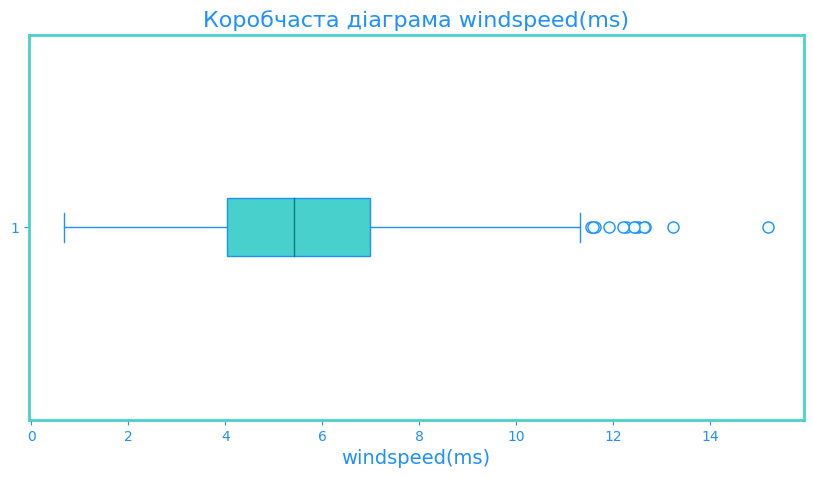

In [32]:
fig, ax = plt.subplots(figsize=(10, 5))

# Коробчаста діаграма для windspeed(ms)
box = ax.boxplot(df['windspeed(ms)'], vert=False, patch_artist=True,
                 boxprops=dict(facecolor='mediumturquoise', color='dodgerblue'),
                 whiskerprops=dict(color='dodgerblue'),
                 capprops=dict(color='dodgerblue'),
                 medianprops=dict(color='teal'),
                 flierprops=dict(marker='o', markerfacecolor='azure', markeredgecolor='dodgerblue', markersize=8))  # Изменение цвета выбросов

# Налаштування кольорової рамки навколо графіка
for spine in ax.spines.values():
    spine.set_edgecolor('mediumturquoise')
    spine.set_linewidth(2)

# Налаштування заголовка та підписів осей
ax.set_title('Коробчаста діаграма windspeed(ms)', color='dodgerblue', fontsize=16)
ax.set_xlabel('windspeed(ms)', color='dodgerblue', fontsize=14)

# Зміна кольору значень тікерів
ax.tick_params(axis='x', colors='dodgerblue')
ax.tick_params(axis='y', colors='dodgerblue')

plt.show()

- windspeed(ms) та windspeed(mph) дублюють один одного і модель його виключає, тому що досить одного windspeed(mph) для знаходження залежності. Чим більша швидкість вітру тим менша кількість прокатів.

### Висновок
Отже, ми подивилися, як можна стежити за адекватністю лінійної моделі, як відбирати ознаки і як грамотно, за можливості не налаштовуючись на якусь конкретну порцію даних, підбирати коефіцієнт регуляризації.

Варто зазначити, що за допомогою крос-валідації зручно підбирати лише невелику кількість параметрів. (1, 2, максимум 3), тому що для кожної допустимої їх комбінації нам доводиться декілька разів навчати модель. Такий процес займає багато часу, особливо якщо треба навчатися на великих обсягах даних.